# Stroke Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 3.1 Imports<a id='4.3_Imports'></a>

In [1]:
import os
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, roc_curve, precision_recall_curve
from sklearn.inspection import plot_partial_dependence

def precision_recall_plot(X: pd.DataFrame, y: pd.Series, model) -> None:
    """
    Return the precision/recall plot of the input data
    :param X:  X input as pandas dataframe
    :param y:  y input as pandas series
    :return: Plot of precision vs. recall
    """
    probs = np.array(model.predict_proba(X)[:, 1])
    precision, recall, thresh = precision_recall_curve(y, probs)
    plt.plot(thresh, precision[:-1], 'b--', label='Precision')
    plt.plot(thresh, recall[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.show()
    
def get_classification_report(X: pd.DataFrame, y: pd.Series, model, threshold) -> None:
    """
    Return classification report of input data and threshold
    :param X:  X input as pandas dataframe
    :param y:  y input as pandas series
    :param threshold: Binary prediction threshold between (0,1)
    :return:
    """
    probs = model.predict_proba(X)[::, 1]
    predictions = np.where(probs >= threshold, 1, 0)
    print(classification_report(y, predictions))

## Load Data

In [2]:
stroke_data = pd.read_csv('../data/stroke_data_cleaned.csv')
stroke_data.head().T

,0,1,2,3,4
gender,1.00,0.000000,1.00,0.00,0.00
age,67.00,61.000000,80.00,49.00,79.00
hypertension,0.00,0.000000,0.00,0.00,1.00
heart_disease,1.00,0.000000,1.00,0.00,0.00
ever_married,1.00,1.000000,1.00,1.00,1.00
avg_glucose_level,228.69,202.210000,105.92,171.23,174.12
bmi,36.60,28.893237,32.50,34.40,24.00
smoking_status,1.00,0.000000,0.00,1.00,0.00
stroke,1.00,1.000000,1.00,1.00,1.00
residence_type,1.00,0.000000,0.00,1.00,0.00


In [3]:
stroke_data.shape

(5109, 10)

In [4]:
stroke_data.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

### Split X/Y

In [5]:
X = stroke_data.drop('stroke', axis=1)
y = stroke_data[['stroke']]

In [6]:
y.value_counts() #imbalanced dataset

stroke
0         4860
1          249
dtype: int64

# Modeling
There are 3 models that I will use here: Logistic Regression, Random Forest, and Gradient Boosting. 

## Logistic Regression

##### Fit logistic model

In [7]:
#Applying Standardization using StandardScaler().  Since we're using a logistic regression...good to use scaling.
columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=columns)
X_std.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,residence_type
0,1.189791,1.051242,-0.328637,4.184599,0.723678,2.706450,1.001041,1.433107,0.983884
1,-0.840484,0.785889,-0.328637,-0.238972,0.723678,2.121652,-0.000165,-0.697785,-1.016380
2,1.189791,1.626174,-0.328637,4.184599,0.723678,-0.004867,0.468399,-0.697785,-1.016380
3,-0.840484,0.255182,-0.328637,-0.238972,0.723678,1.437473,0.715233,1.433107,0.983884
4,-0.840484,1.581949,3.042866,-0.238972,0.723678,1.501297,-0.635858,-0.697785,-1.016380


In [8]:
#train and test split for standardized features.
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=45)

In [9]:
X_train.shape, X_test.shape 

((3576, 9), (1533, 9))

##### Fit logistic model

In [10]:
lr_std = LogisticRegression(solver='lbfgs') #had to add a solver 'lbfgs'
lr_std.fit(X_train, y_train.values.ravel()) #had to add .values.ravel() to silence warning

LogisticRegression()

##### Predict on the test set for scoring/diagnostics

In [11]:
y_pred = lr_std.predict(X_test)
y_prob = lr_std.predict_proba(X_test)[::, 1]

<AxesSubplot:>

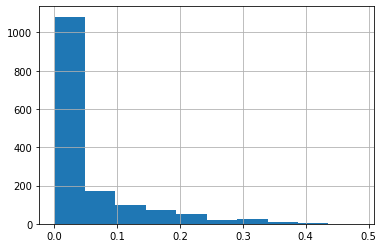

In [12]:
pd.Series(y_prob).hist(bins=10)

In [13]:
pd.Series(y_pred).value_counts() ### We're getting all 0s...since data is imbalanced.  Need to change threshold.

0    1533
dtype: int64

##### Metrics

ACU Score - Doing better than random which is 0.5...so the model is learning

In [14]:
print(roc_auc_score(y_test, y_prob)) # Make sure to use the probability instead of the prediction value

0.8449802964908989


Precision/Recall Plot - Let's find that ideal threshold number

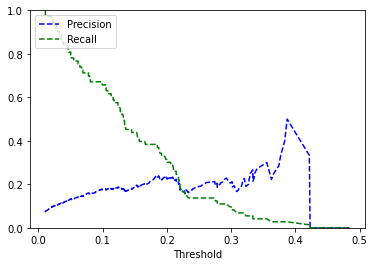

In [15]:
precision_recall_plot(X_test, y_test, lr_std)

Classification report - Let's see how well we're doing with precision and recall for stroke/non-stroke

In [16]:
get_classification_report(X_test, y_test, lr_std, threshold=0.35)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1460
           1       0.30      0.04      0.07        73

    accuracy                           0.95      1533
   macro avg       0.63      0.52      0.52      1533
weighted avg       0.92      0.95      0.93      1533



**Maybe we set the threshold to around 0.35??? since we're doing well at being precise for stroke cases**

In [56]:
#Logistic Regression - Accuracy Score
Accuracy_lr = accuracy_score(y_test, y_pred)
print('Accuracy score: ' +str(Accuracy_lr))

Accuracy score: 0.9523809523809523


In [18]:
#Logistic Regression - Cross Validation Score
cv_scores_test= cross_val_score(lr_std, X_test, y_test.values.ravel(), cv=5, scoring='roc_auc')
cv_scores_train= cross_val_score(lr_std, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.76826484 0.8390411  0.85251142 0.90680039 0.83928571]
Mean cross validation test score: 0.841180691454664
Mean cross validation train score: 0.8387682072829131
Standard deviation in cv test scores: 0.044179679722383326


## Random Forest

##### Preprocessing the data 
We don't want scaled since doing a tree based model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

##### Fit the model
Doing a grid search this time since random forests have a lot of parameters to tune

In [20]:
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 3, 4],
    'criterion' :['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)

In [21]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100]})

In [22]:
best_rfc = grid_search.best_estimator_
best_rfc # Getting the best model out of the set of models that were searched

RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)

##### Predict on the test set for scoring/diagnostics

In [23]:
y_pred = best_rfc.predict(X_test)
y_prob = best_rfc.predict_proba(X_test)[::, 1]

<AxesSubplot:>

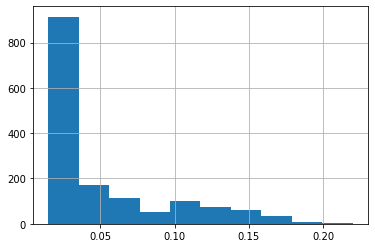

In [24]:
pd.Series(y_prob).hist(bins=10)

In [25]:
pd.Series(y_pred).value_counts() ### We're getting all 0s...since data is imbalanced.  Need to change threshold.

0    1533
dtype: int64

##### Metrics

ACU Score - Model still learned!

In [26]:
print(roc_auc_score(y_test, y_prob)) # Make sure to use the probability instead of the prediction value

0.8385485081628823


Precision/Recall Plot - Let's find that ideal threshold number

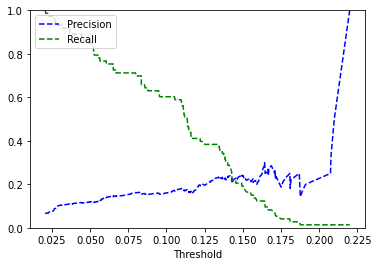

In [27]:
precision_recall_plot(X_test, y_test, best_rfc)

Classification report - Let's see how well we're doing with precision and recall for stroke/non-stroke

In [28]:
get_classification_report(X_test, y_test, best_rfc, threshold=0.11)

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1460
           1       0.18      0.56      0.27        73

    accuracy                           0.86      1533
   macro avg       0.58      0.72      0.59      1533
weighted avg       0.94      0.86      0.89      1533



**Maybe we set the threshold to around 0.12??? since we're doing well at being precise for stroke cases**

##### Model Explanation
Let's start to understand what is being learned by the model

Feature importance - This will show us which variable have the greatest impact (not necessarily direction)
to prediction stroke/not

In [29]:
rfc_feature_importance = pd.Series(best_rfc.feature_importances_, index=X.columns)

<AxesSubplot:>

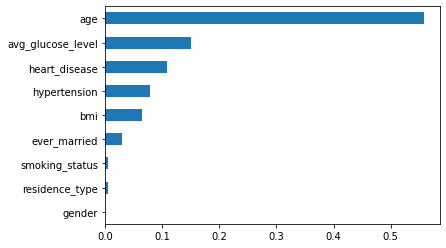

In [30]:
rfc_feature_importance.nlargest(10).sort_values(ascending=True).plot.barh()

Partial Dependence - This will show us direction and when we'd expect increases in stroke likelihood for a given
variable

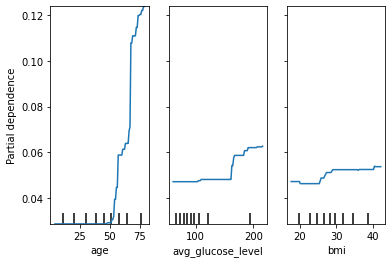

In [31]:
plot_partial_dependence(best_rfc, X_test, features=['age', 'avg_glucose_level', 'bmi'])

In [53]:
#Random Forest - Accuracy Score
Accuracy_rfc = best_rfc.score(X_test,y_test)
print('Accuracy score: ' +str(Accuracy_rfc))

Accuracy score: 0.9523809523809523


In [33]:
#Random Forest - Cross Validation Score
cv_scores_test= cross_val_score(best_rfc, X_test, y_test.values.ravel(), cv=5, scoring='roc_auc')
cv_scores_train= cross_val_score(best_rfc, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores_test)
cv_scores_rfc_test= cv_scores_test.mean()
cv_scores_rfc_train= cv_scores_train.mean()
cv_scores_std_test_rfc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfc_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rfc))

[0.71038813 0.82477169 0.86518265 0.90203033 0.83390411]
Mean cross validation test score: 0.8272553816046967
Mean cross validation train score: 0.8423487394957985
Standard deviation in cv test scores: 0.06440201888872178


## Gradient Boosting 

##### Fit the model
Doing GridSearch again for Gradient Boosting.

In [34]:
# TODO Let's fit, tune using grid search and get diagnostic information 
# (i.e. auc, classification report, feature importance, etc)

In [35]:
gbc = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth' : [2, 3, 4, 5, 6]
}
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3)

In [36]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100]})

In [37]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=50)

##### Predict on the test set for scoring/diagnostics

In [38]:
y_pred = best_gbc.predict(X_test)
y_prob = best_gbc.predict_proba(X_test)[::, 1]

<AxesSubplot:>

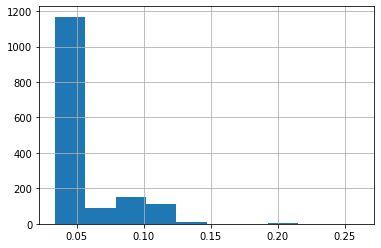

In [39]:
pd.Series(y_prob).hist(bins=10)

In [40]:
pd.Series(y_pred).value_counts()

0    1533
dtype: int64

##### Metrics
AUC Score - did model learn?

In [41]:
print(roc_auc_score(y_test, y_prob)) #not as good as random forest

0.8309908050290861


Precision/Recall Plot - Ideal threshold number for Gradient Boosting?

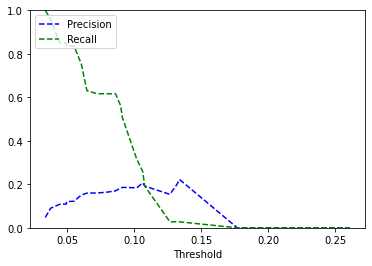

In [42]:
precision_recall_plot(X_test, y_test, best_gbc)

Classification report - Let's see how well we're doing with precision and recall for stroke/non-stroke

In [43]:
get_classification_report(X_test, y_test, best_gbc, threshold=0.06)

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      1460
           1       0.15      0.75      0.25        73

    accuracy                           0.79      1533
   macro avg       0.57      0.77      0.56      1533
weighted avg       0.94      0.79      0.85      1533



In [44]:
get_classification_report(X_test, y_test, best_gbc, threshold=0.12)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1460
           1       0.15      0.03      0.05        73

    accuracy                           0.95      1533
   macro avg       0.55      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533



Maybe set threshold to 0.06 since recall is better for that range of number.

##### Model Explanation
Feature Importance & Partial Dependence Plots

In [45]:
gbc_feature_importance = pd.Series(best_gbc.feature_importances_, index=X.columns)

<AxesSubplot:>

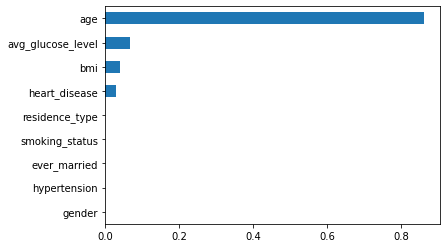

In [46]:
gbc_feature_importance.nlargest(10).sort_values(ascending=True).plot.barh()

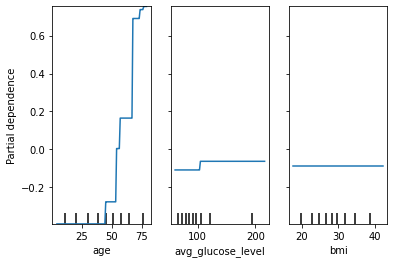

In [47]:
plot_partial_dependence(best_gbc, X_test, features=['age', 'avg_glucose_level', 'bmi'])

In [48]:
#Gradient Boosting - Accuracy Score
Accuracy_gbc = best_gbc.score(X_test,y_test)
print('Accuracy score: ' +str(Accuracy_gbc))

Accuracy score: 0.9523809523809523


In [49]:
#Gradient Boosting - Cross Validation Score
cv_scores_test= cross_val_score(best_gbc, X_test, y_test.values.ravel(), cv=5, scoring='roc_auc')
cv_scores_train= cross_val_score(best_gbc, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_test_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_gbc))

[0.70308219 0.7880137  0.75388128 0.90264188 0.83671722]
Mean cross validation test score: 0.7968672537508154
Mean cross validation train score: 0.8182607376283848
Standard deviation in cv test scores: 0.06855378695459682


## Compare the models and draw insights
What variable have and impact (in-depth on the columns)

We applied different ML models above and evaluated their performances in terms of ROC-AUC score for both the training and test data. Here we have tabulated the scores and plotted them.
Clearly, the Logistic Regression, and the Random Forest are the two best performing models. Both of the models are ensembled, based on decision trees.
So, we will perform a grid search/ hyperparameter tuning for those two ML models.

In [50]:
myLabels = ['Logistic Regression', 'Random Forest', 'Gradient Boost']
score_test= [cv_scores_lr_test, cv_scores_rfc_test, cv_scores_gbc_test]
score_train= [ cv_scores_lr_train, cv_scores_rfc_train, cv_scores_gbc_train]
Accuracy_score = [Accuracy_lr, Accuracy_rfc, Accuracy_gbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab 
#I don't quite understand why the accuracy score is the same for all models?

             Algorithm  Model accuracy score
0  Logistic Regression              0.952381
1        Random Forest              0.952381
2       Gradient Boost              0.952381


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.838768,0.841181
1,Random Forest,0.842349,0.827255
2,Gradient Boost,0.818261,0.796867


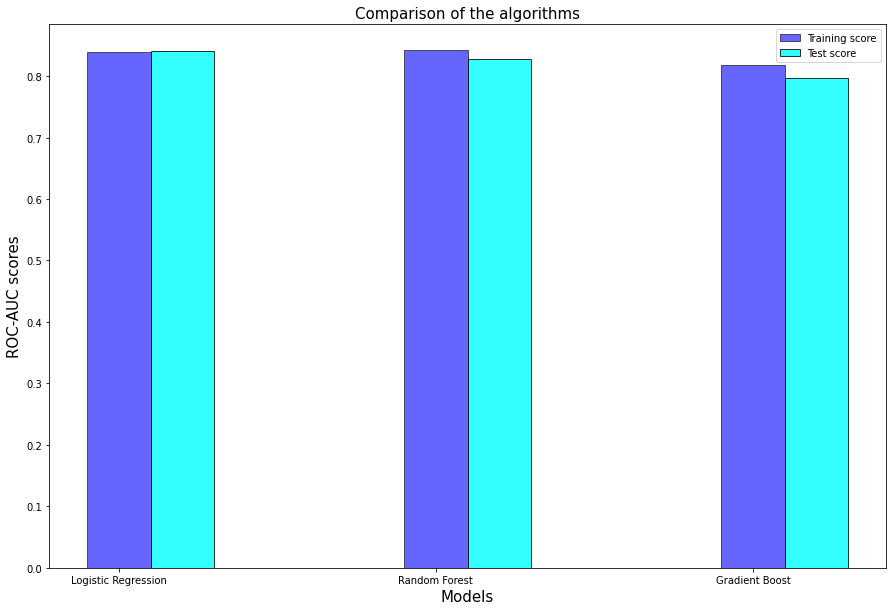

In [51]:
#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(15,10))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)

_ = plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_ = plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

Here we see that Random Forest has the best ROC_AUC scores for the training. Logistic Regression, however, has the best scores for testing.

##### Hyperparameter Tuning

Now its time to Fit both the Logistic Regression and Random Forest models with the optimal hyperparameters. 

In [57]:
#Random Forest - Parameter Tuning 
rfc = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100,400,700,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 3, 4],
    'criterion' :['gini', 'entropy'],
    "min_samples_leaf" : [1, 5, 10],
    "min_samples_split" : [2, 4, 10,12,16]
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

best_rfc = grid_search.best_estimator_
best_score_rfc = grid_search.best_score_
print(best_rfc)
print(best_score_rfc)

#example
#rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)
#param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}
#gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
#gs = gs.fit(X_train, y_train)
#print(gs.best_estimator_) 
#print(gs.best_score_)

RandomForestClassifier(max_depth=2, n_estimators=50, n_jobs=-1, random_state=1)
0.9507829977628636


In [65]:
#Random Forest - Fitting with optimal hyperparameters
rfc_hp = RandomForestClassifier(max_depth=2, n_estimators=50, n_jobs=-1, random_state=1)

rfc_hp.fit(X_train, y_train.values.ravel()) #y_train.values.ravel()

y_pred_rfc_hp = rfc_hp.predict(X_test)
acc = accuracy_score(y_test, y_pred_rfc_hp)
cv = cross_val_score(rfc_hp, X_test, y_test,scoring='roc_auc').mean()
print(acc)
print(cv)

#example
#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            #max_depth=None, max_features='auto', max_leaf_nodes=None,
            #min_impurity_decrease=0.0, min_impurity_split=None,
            #min_samples_leaf=1, min_samples_split=2,
            #min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            #oob_score=False, random_state=1, verbose=0, warm_start=False)
#rf.fit(X_train, y_train)
#y_predictions_rf = rf.predict(X_test)
#acc = accuracy_score(y_test, y_predictions)
#cv = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
#print(acc)
#print(cv)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y wa

0.9523809523809523
0.8324494455316372


<AxesSubplot:>

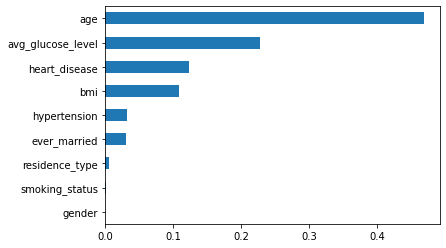

In [66]:
#Random Forest - Feature Importances
rfc_hp_feature_importance = pd.Series(best_rfc.feature_importances_, index=X.columns)
rfc_hp_feature_importance.nlargest(10).sort_values(ascending=True).plot.barh()

#example